In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy
import torch.nn.functional as F
import copy
from torch import nn
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv
from torch.nn import Module, Parameter

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Variational Graph AutoEncoder

In [3]:
def sparse_degree_matrix(A) -> torch.sparse.FloatTensor:
    D = scipy.sparse.spdiags(torch.sparse.sum(A, dim=1).to_dense(),0, *A.shape).tocoo()
    return coo_to_torch_sparse_matrix(D)

In [4]:
def coo_to_torch_sparse_matrix(coo):
    idx = torch.LongTensor(coo.nonzero())
    data = torch.FloatTensor(coo.data)
    return torch.sparse.FloatTensor(idx, data)

In [5]:
def laplacian(A, normalized=True):
    I = torch.eye(A.shape[0])
    D = sparse_degree_matrix(A)
    if not normalized:
        L = D.sub(A)
    else:
        D = (D**(-0.5)).to_dense()
        p1 = torch.spmm(A, D)
        L = torch.mm(p1, D)
        # L = coo_to_torch_sparse_matrix(scipy.sparse.coo_matrix(I - p2))

    return L

In [6]:
def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy

In [7]:
M_test = torch.sparse.FloatTensor(data.edge_index, torch.FloatTensor(np.repeat(1, len(data.edge_index[1]))))
# L = laplacian(M_test)
L = M_test.to_dense()

In [8]:
class GraphConvolutionLayer(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

In [9]:
class VGAE(Module):
    def __init__(self, nfeat, nhid, dimz, n_samples):
        super(VGAE, self).__init__()
        self.n_samples = n_samples
        self.nhid = nhid
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2mu = GraphConvolutionLayer(nhid, dimz)
        self.gc2std = GraphConvolutionLayer(nhid, dimz)
        
    def encode(self, x, adj):
        # First GCN
        x = F.relu(self.gc1(x, adj))
        # Mean and std
        self.mean = self.gc2mu(x, adj)
        self.log_std = self.gc2std(x, adj)
        # Latent representation
        return self.mean + torch.mul(self.log_std, torch.randn_like(self.log_std))
        
    def decode(self, z):
        return torch.sigmoid(torch.matmul(z, z.t()))
        
    def forward(self, x, adj):
        z = self.encode(x, adj)
        A_recon = self.decode(z)
        return A_recon
    
    def loss(self, A_hat, A, norm, weight_tensor):
        # Binary Crossentropy loss
        # bce_loss = nn.BCELoss(reduce='sum')(A_hat, A)
        bce_loss = norm * F.binary_cross_entropy(A_hat.view(-1), A.view(-1), weight = weight_tensor)
        # KL Loss
        # kl_loss = - 0.5 * torch.mean(torch.sum(1 + self.log_std - self.mean.pow(2) - self.log_std.exp(), dim=1)) 
        # kl_loss = nn.KLDivLoss(reduce='batchmean')(torch.log(A_hat), A)
        kl_loss = 0.5/ A_hat.size(0) * (1 + 2*self.log_std - self.mean**2 - torch.exp(self.log_std)).sum(1).mean()
        
        return bce_loss - kl_loss
        

In [10]:
vgae = VGAE(1433, 32, 16, data.x.shape[0])
optimizer = optim.Adam(vgae.parameters(), lr=0.01)

pos_weight = float(L.shape[0] * L.shape[0] - L.sum()) / L.sum()
norm = L.shape[0] * L.shape[0] / float((L.shape[0] * L.shape[0] - L.sum()) * 2)
L += torch.eye(*L.shape)
weight_mask = L.view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

In [11]:
import tqdm
loss_history = np.zeros(200) 

for epoch in tqdm.trange(200): 
  
    optimizer.zero_grad()
    A_hat = vgae(torch.eye(*data.x.shape), L)
    loss = vgae.loss(A_hat, L, norm, weight_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0: print("Accuracy: " + str(get_acc(A_hat, L).detach()))

    loss_history[epoch] = loss.detach().numpy()

  0%|          | 1/200 [00:00<01:22,  2.40it/s]

Accuracy: tensor(0.1957)


 10%|█         | 21/200 [00:07<01:02,  2.86it/s]

Accuracy: tensor(0.4488)


 20%|██        | 41/200 [00:13<00:51,  3.09it/s]

Accuracy: tensor(0.4797)


 30%|███       | 61/200 [00:19<00:44,  3.14it/s]

Accuracy: tensor(0.4960)


 40%|████      | 81/200 [00:25<00:38,  3.06it/s]

Accuracy: tensor(0.5162)


 50%|█████     | 101/200 [00:32<00:35,  2.75it/s]

Accuracy: tensor(0.5336)


 60%|██████    | 121/200 [00:38<00:25,  3.09it/s]

Accuracy: tensor(0.5356)


 70%|███████   | 141/200 [00:45<00:20,  2.86it/s]

Accuracy: tensor(0.5454)


 80%|████████  | 161/200 [00:51<00:13,  2.97it/s]

Accuracy: tensor(0.5493)


 90%|█████████ | 181/200 [00:57<00:06,  3.14it/s]

Accuracy: tensor(0.5498)


100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


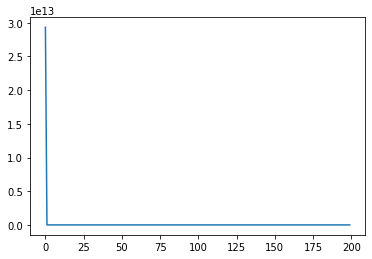

29323920670720.0
0.600739598274231
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
tensor([[0.9871, 0.7159, 0.4707,  ..., 0.4981, 0.8071, 0.7783],
        [0.7159, 0.9951, 0.9906,  ..., 0.6748, 0.4106, 0.5143],
        [0.4707, 0.9906, 0.9968,  ..., 0.4223, 0.3346, 0.3982],
        ...,
        [0.4981, 0.6748, 0.4223,  ..., 0.8997, 0.6448, 0.6180],
        [0.8071, 0.4106, 0.3346,  ..., 0.6448, 0.9933, 0.9465],
        [0.7783, 0.5143, 0.3982,  ..., 0.6180, 0.9465, 0.9153]])


In [12]:
plt.plot(loss_history)
plt.show()
print(loss_history[0])
print(loss_history[len(loss_history) -1])
print(L, A_hat.data, sep='\n')

## GCN vs VGAE

In [13]:
def test(model, A):
    model.eval()
    _, pred = model(data.x, A).max(dim=1)
    correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()
    print('Accuracy: {:.4f}'.format(acc))

In [14]:
class GCN(Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolutionLayer(nfeat, nhid)
        self.gc2 = GraphConvolutionLayer(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [15]:
VGAE_A = A_hat.data.clone()
VGAE_A = (VGAE_A > 0.5).float()

In [16]:
gcn1 = GCN(1433, 50, 7)
gcn2 = GCN(1433, 50, 7)
optimizer_gcn_1 = optim.Adam(gcn1.parameters())
optimizer_gcn_2 = optim.Adam(gcn2.parameters())
criterion = nn.CrossEntropyLoss()

### GCN

In [20]:
del loss_history, loss

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_1.zero_grad()
    outputs = gcn1(data.x, L) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_1.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 2500/2500 [01:35<00:00, 26.20it/s]


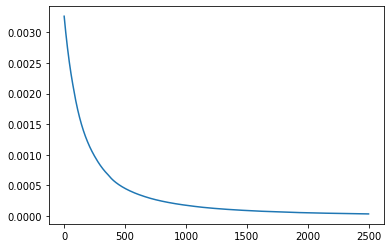

In [21]:
plt.plot(loss_history)
plt.show()

In [22]:
print(loss_history[len(loss_history) -1])
test(gcn1, L)

3.254430339438841e-05
Accuracy: 0.6620


### VGAE

In [23]:
del loss_history, loss

import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn_2.zero_grad()
    outputs = gcn2(data.x, VGAE_A) # Usiamo tutto il dataset
    loss = criterion(outputs[data.train_mask], data.y[data.train_mask]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn_2.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 2500/2500 [01:35<00:00, 26.05it/s]


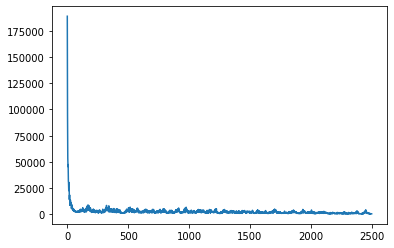

In [24]:
plt.plot(loss_history)
plt.show()

In [25]:
print(loss_history[len(loss_history) -1])
test(gcn2, VGAE_A)

495.5546875
Accuracy: 0.3480
